# Test changing marinheatwaves package to use cftime

In [1]:
# Import some useful packages
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
from datetime import date
import cftime
import matplotlib.pyplot as plt
import cmocean

# Import the marineHeatWaves package
import marineHeatWaves as mhw

## Set read and write paths

In [2]:
# path to all post-processed (pp) data
rootdir = ('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'+
           'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/'+
           'pp/')
# specific pp directory
ppname = 'ocean_daily_1x1deg'
# local directory
localdir = '/ts/daily/5yr/'
# Now specify the name of the file you want to open
# NOTE that the filenames always start with the same ppname,
# so I can save some hassle here...
# Use wildcards to grab the years 101 - 200
filename = ppname +'.01[0123456789][16]0101-0[12][0123456789][50]1231.tos.nc'

In [3]:
# The combination of all these defines the path
path = rootdir+ppname+localdir+filename

## Import data

In [4]:
# Load the file using xarray
# For memory reasons, we are going to "chunk" the data in the time dimension
ds = xr.open_mfdataset(path,use_cftime=True,combine='by_coords',engine='netcdf4',
                       drop_variables=['average_DT', 'average_T1', 'average_T2']).chunk({'time':365})

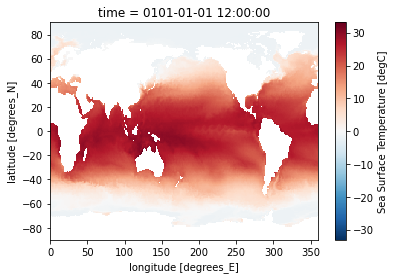

In [5]:
ds['tos'].isel(time=0).plot()
plt.show()

### Subset data
Select a single latitude and longitude (note that we are doing this with the "nominal" coordinate here, so it is not 100% accurate for that location (see discussion in the plotting geodata tutorial). However, it is good enough for our purposes.  

We will also load/compute the data into memory here, which may take several minutes.

In [6]:
# Pick a spot in the Atlantic, on the equator
temp = ds['tos'].sel(lon=165,lat=-5,method='nearest')
with ProgressBar():
    temp = temp.compute()

[########################################] | 100% Completed | 18.5s


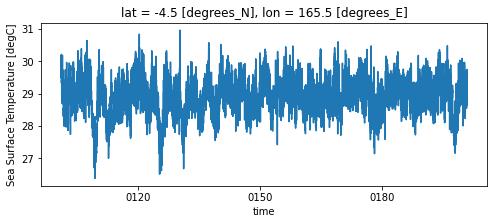

In [7]:
# Quick check of what the time-series looks like
temp.plot(figsize=(8,3))
plt.show()

## Start testing pkg code

### Set defaults

In [18]:
climatologyPeriod=[None,None]
pctile=0.9
smoothPercentile=True
smoothPercentileWidth=31
minDuration=5
joinAcrossGaps=True
maxGap=2
coldSpells=False
alternateClimatology=False
Ly=False

### Initialize MHW output variable

In [9]:
mhw = {}
mhw['time_start'] = [] # datetime format
mhw['time_end'] = [] # datetime format
mhw['time_peak'] = [] # datetime format
mhw['date_start'] = [] # datetime format
mhw['date_end'] = [] # datetime format
mhw['date_peak'] = [] # datetime format
mhw['index_start'] = []
mhw['index_end'] = []
mhw['index_peak'] = []
mhw['duration'] = [] # [days]
mhw['duration_moderate'] = [] # [days]
mhw['duration_strong'] = [] # [days]
mhw['duration_severe'] = [] # [days]
mhw['duration_extreme'] = [] # [days]
mhw['intensity_max'] = [] # [deg C]
mhw['intensity_mean'] = [] # [deg C]
mhw['intensity_var'] = [] # [deg C]
mhw['intensity_cumulative'] = [] # [deg C]
mhw['intensity_max_relThresh'] = [] # [deg C]
mhw['intensity_mean_relThresh'] = [] # [deg C]
mhw['intensity_var_relThresh'] = [] # [deg C]
mhw['intensity_cumulative_relThresh'] = [] # [deg C]
mhw['intensity_max_abs'] = [] # [deg C]
mhw['intensity_mean_abs'] = [] # [deg C]
mhw['intensity_var_abs'] = [] # [deg C]
mhw['intensity_cumulative_abs'] = [] # [deg C]
mhw['category'] = []
mhw['rate_onset'] = [] # [deg C / day]
mhw['rate_decline'] = [] # [deg C / day]

### Time and dates vectors

In [24]:
# Generate vectors for year, month, day-of-month, and day-of-year
year = temp['time'].dt.year.values
doy = temp['time'].dt.dayofyear.values

In [20]:
# Set climatology period, if unset use full range of available data
if (climatologyPeriod[0] is None) or (climatologyPeriod[1] is None):
    climatologyPeriod[0] = year[0]
    climatologyPeriod[1] = year[-1]

### Calculate threshold and seasonal climatology (varying with day-of-year)

In [21]:
# if alternate temperature time series is supplied for the calculation of the climatology
if alternateClimatology:
    tempClim = alternateClimatology
else:
    tempClim = temp.copy()

In [22]:
# Flip temp time series if detecting cold spells
if coldSpells:
    temp = -1.*temp
    tempClim = -1.*tempClim

In [23]:
# Truncate climatology to given period
tempClim = tempClim.sel(time=slice(str(climatologyPeriod[0]).zfill(4),str(climatologyPeriod[-1]).zfill(4)))

In [26]:
# Inialize arrays
clim = {}
# calculate threshold and seasonal climatology across years
thresh_climYear = tempClim.groupby('time.dayofyear').quantile(pctile)
seas_climYear = tempClim.groupby('time.dayofyear').mean()

In [36]:
# Generate threshold for full time series
clim['thresh'] = thresh_climYear.values[doy.astype(int)-1]
clim['seas'] = seas_climYear.values[doy.astype(int)-1]

### Find MHWs as exceedances above the threshold

In [ ]:
# Time series of "True" when threshold is exceeded, "False" otherwise
exceed_bool = temp.values - clim['thresh']
exceed_bool[exceed_bool<=0] = False
exceed_bool[exceed_bool>0] = True
# Fix issue where missing temp vaues (nan) are counted as True
exceed_bool[np.isnan(exceed_bool)] = False
# Find contiguous regions of exceed_bool = True
events, n_events = ndimage.label(exceed_bool)

In [ ]:
# Find all MHW events of duration >= minDuration
for ev in range(1,n_events+1):
    event_duration = (events == ev).sum()
    if event_duration < minDuration:
        continue
    mhw['time_start'].append(t[np.where(events == ev)[0][0]])
    mhw['time_end'].append(t[np.where(events == ev)[0][-1]])

In [ ]:
# Link heat waves that occur before and after a short gap (gap must be no longer than maxGap)
if joinAcrossGaps:
    # Calculate gap length for each consecutive pair of events
    gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
    if len(gaps) > 0:
        while gaps.min() <= maxGap:
            # Find first short gap
            ev = np.where(gaps <= maxGap)[0][0]
            # Extend first MHW to encompass second MHW (including gap)
            mhw['time_end'][ev] = mhw['time_end'][ev+1]
            # Remove second event from record
            del mhw['time_start'][ev+1]
            del mhw['time_end'][ev+1]
            # Calculate gap length for each consecutive pair of events
            gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
            if len(gaps) == 0:
                break

In [ ]:
# Calculate marine heat wave properties
mhw['n_events'] = len(mhw['time_start'])
categories = np.array(['Moderate', 'Strong', 'Severe', 'Extreme'])
for ev in range(mhw['n_events']):
    mhw['date_start'].append(date.fromordinal(mhw['time_start'][ev]))
    mhw['date_end'].append(date.fromordinal(mhw['time_end'][ev]))
    # Get SST series during MHW event, relative to both threshold and to seasonal climatology
    tt_start = np.where(t==mhw['time_start'][ev])[0][0]
    tt_end = np.where(t==mhw['time_end'][ev])[0][0]
    mhw['index_start'].append(tt_start)
    mhw['index_end'].append(tt_end)
    temp_mhw = temp[tt_start:tt_end+1]
    thresh_mhw = clim['thresh'][tt_start:tt_end+1]
    seas_mhw = clim['seas'][tt_start:tt_end+1]
    mhw_relSeas = temp_mhw - seas_mhw
    mhw_relThresh = temp_mhw - thresh_mhw
    mhw_relThreshNorm = (temp_mhw - thresh_mhw) / (thresh_mhw - seas_mhw)
    mhw_abs = temp_mhw
    # Find peak
    tt_peak = np.argmax(mhw_relSeas)
    mhw['time_peak'].append(mhw['time_start'][ev] + tt_peak)
    mhw['date_peak'].append(date.fromordinal(mhw['time_start'][ev] + tt_peak))
    mhw['index_peak'].append(tt_start + tt_peak)
    # MHW Duration
    mhw['duration'].append(len(mhw_relSeas))
    # MHW Intensity metrics
    mhw['intensity_max'].append(mhw_relSeas[tt_peak])
    mhw['intensity_mean'].append(mhw_relSeas.mean())
    mhw['intensity_var'].append(np.sqrt(mhw_relSeas.var()))
    mhw['intensity_cumulative'].append(mhw_relSeas.sum())
    mhw['intensity_max_relThresh'].append(mhw_relThresh[tt_peak])
    mhw['intensity_mean_relThresh'].append(mhw_relThresh.mean())
    mhw['intensity_var_relThresh'].append(np.sqrt(mhw_relThresh.var()))
    mhw['intensity_cumulative_relThresh'].append(mhw_relThresh.sum())
    mhw['intensity_max_abs'].append(mhw_abs[tt_peak])
    mhw['intensity_mean_abs'].append(mhw_abs.mean())
    mhw['intensity_var_abs'].append(np.sqrt(mhw_abs.var()))
    mhw['intensity_cumulative_abs'].append(mhw_abs.sum())
    # Fix categories
    tt_peakCat = np.argmax(mhw_relThreshNorm)
    cats = np.floor(1. + mhw_relThreshNorm)
    mhw['category'].append(categories[np.min([cats[tt_peakCat], 4]).astype(int) - 1])
    mhw['duration_moderate'].append(np.sum(cats == 1.))
    mhw['duration_strong'].append(np.sum(cats == 2.))
    mhw['duration_severe'].append(np.sum(cats == 3.))
    mhw['duration_extreme'].append(np.sum(cats >= 4.))

    # Rates of onset and decline
    # Requires getting MHW strength at "start" and "end" of event (continuous: assume start/end half-day before/after first/last point)
    if tt_start > 0:
        mhw_relSeas_start = 0.5*(mhw_relSeas[0] + temp[tt_start-1] - clim['seas'][tt_start-1])
        mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas_start) / (tt_peak+0.5))
    else: # MHW starts at beginning of time series
        if tt_peak == 0: # Peak is also at begining of time series, assume onset time = 1 day
            mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
        else:
            mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / tt_peak)
    if tt_end < T-1:
        mhw_relSeas_end = 0.5*(mhw_relSeas[-1] + temp[tt_end+1] - clim['seas'][tt_end+1])
        mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas_end) / (tt_end-tt_start-tt_peak+0.5))
    else: # MHW finishes at end of time series
        if tt_peak == T-1: # Peak is also at end of time series, assume decline time = 1 day
            mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / 1.)
        else:
            mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))

In [ ]:
# Flip climatology and intensties in case of cold spell detection
if coldSpells:
    clim['seas'] = -1.*clim['seas']
    clim['thresh'] = -1.*clim['thresh']
    for ev in range(len(mhw['intensity_max'])):
        mhw['intensity_max'][ev] = -1.*mhw['intensity_max'][ev]
        mhw['intensity_mean'][ev] = -1.*mhw['intensity_mean'][ev]
        mhw['intensity_cumulative'][ev] = -1.*mhw['intensity_cumulative'][ev]
        mhw['intensity_max_relThresh'][ev] = -1.*mhw['intensity_max_relThresh'][ev]
        mhw['intensity_mean_relThresh'][ev] = -1.*mhw['intensity_mean_relThresh'][ev]
        mhw['intensity_cumulative_relThresh'][ev] = -1.*mhw['intensity_cumulative_relThresh'][ev]
        mhw['intensity_max_abs'][ev] = -1.*mhw['intensity_max_abs'][ev]
        mhw['intensity_mean_abs'][ev] = -1.*mhw['intensity_mean_abs'][ev]
        mhw['intensity_cumulative_abs'][ev] = -1.*mhw['intensity_cumulative_abs'][ev]